In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.cm as cm
import random
import glob
import os
from skimage.segmentation import chan_vese
import numpy as np
import PIL 
from PIL import Image 
from tensorboard.plugins.hparams import api as hp
import pandas as pd
from shutil import copy
import cv2

# Display
# from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# My functions
import my_functions as mf

# tf explain
from tf_explain.callbacks.grad_cam import GradCAMCallback

In [2]:
random_seed = 42

In [3]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width)

In [21]:
def get_img_array_with_contrast(img_path, size):
   img = keras.preprocessing.image.load_img(img_path, target_size=size)
   # `array` is a float32 Numpy array of shape (size, 3)
   array = keras.preprocessing.image.img_to_array(img)

   # Canal destacado
   image_contrast = mf.aply_black_tophat_to_image(img_path)
   new_channel = cv2.resize(image_contrast, dsize=image_size, interpolation=cv2.INTER_AREA)

   # Nova imagem com um canal destacado e outros dois default
   new_image = np.dstack((array[:, :, :2] , new_channel))

   return new_image

In [22]:
def save_new_imgs_with_contrast(src_folder, dest_folder, final_size=(180, 180)):
   list_images_paths = glob.glob(src_folder + "*")
   for current_image_path in list_images_paths:
      image_name = current_image_path.split('\\')[-1]
      result_image = get_img_array_with_contrast(img_path=current_image_path, size=final_size)
      tf.keras.utils.save_img(
         path="{}ctrst_version_{}".format(dest_folder, image_name),
         x=result_image, 
         data_format=None, 
         file_format='png', 
         scale=True
      )

In [23]:
src_folder_path = "datasets\\ct_scan_3\\val\\COVID-positive\\"
dest_folder_path = "datasets\\ct_scan_6\\val\\COVID-positive\\"
save_new_imgs_with_contrast(src_folder_path, dest_folder_path)

In [24]:
src_folder_path = "datasets\\ct_scan_3\\val\\COVID-negative\\"
dest_folder_path = "datasets\\ct_scan_6\\val\\COVID-negative\\"
save_new_imgs_with_contrast(src_folder_path, dest_folder_path)

In [25]:
src_folder_path = "datasets\\ct_scan_3\\train\\COVID-negative\\"
dest_folder_path = "datasets\\ct_scan_6\\train\\COVID-negative\\"
save_new_imgs_with_contrast(src_folder_path, dest_folder_path)

In [26]:
src_folder_path = "datasets\\ct_scan_3\\train\\COVID-positive\\"
dest_folder_path = "datasets\\ct_scan_6\\train\\COVID-positive\\"
save_new_imgs_with_contrast(src_folder_path, dest_folder_path)

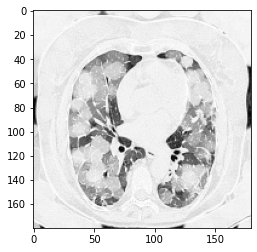

In [27]:
img_path = "datasets\\ct_scan_6\\val\\COVID-positive\\ctrst_version_13_Bjorke_95.png"
new_img_array = mf.get_img_array(img_path, size=image_size)
# preds = model.predict(img_array)
# print(preds)
plt.imshow(new_img_array[0, :, :, 2].astype(int), cmap='Greys')

In [28]:
train_ds = tf.keras.utils.image_dataset_from_directory(
   'datasets/ct_scan_6/train',
   labels='inferred',
   label_mode='int',
   class_names=None,
   color_mode='rgb',
   batch_size=batch_size,
   image_size=image_size,
   shuffle=True, 
   seed=random_seed, 
   interpolation='bilinear',
   follow_links=False,
   crop_to_aspect_ratio=False)

Found 11851 files belonging to 2 classes.


In [29]:
val_ds = tf.keras.utils.image_dataset_from_directory(
   'datasets/ct_scan_3/val',
   labels='inferred',
   label_mode='int',
   class_names=None,
   color_mode='rgb',
   batch_size=batch_size,
   image_size=image_size,
   shuffle=True, 
   seed=random_seed,
   interpolation='bilinear',
   follow_links=False,
   crop_to_aspect_ratio=False)

Found 2632 files belonging to 2 classes.


In [30]:
inputs = keras.Input(shape=(img_height, img_width, 3))

data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal"), 
      layers.RandomRotation(0.1)
    ]
)
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1/127.5, offset=-1)
x = scale_layer(x)
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
base_model = keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3),
    input_tensor=x
)
last_layer_base_model = mf.find_last_layer(base_model)

x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_base_model.output)

x = keras.layers.Dense(units=128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=32, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

base_model.trainable = False # Freeze base model

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 89, 89, 32)   864         rescaling[0][0]                  
______________________________________________________________________________________________

In [31]:
gcam_image_path = "datasets\\ct_scan_3\\val\\COVID-positive\\P021_106.png"

In [32]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

run_logdir = mf.get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

data = (mf.get_img_array(gcam_image_path, image_size), None)
grd_cam_callback = GradCAMCallback(
   validation_data=data,
   class_index=0,
   output_dir=run_logdir,
)

epochs = 100
base_model.trainable = False
model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=32,
    validation_data=val_ds,
    callbacks=[
      tensorboard_cb, 
      early_stopping_cb, 
      grd_cam_callback])

Epoch 1/100
371/371 [==============================] - 83s 190ms/step - loss: 0.6031 - accuracy: 0.6908 - val_loss: 0.4899 - val_accuracy: 0.7834
Epoch 2/100
371/371 [==============================] - 54s 146ms/step - loss: 0.4838 - accuracy: 0.7587 - val_loss: 0.4484 - val_accuracy: 0.7937
Epoch 3/100
371/371 [==============================] - 54s 146ms/step - loss: 0.4766 - accuracy: 0.7741 - val_loss: 0.5090 - val_accuracy: 0.7914
Epoch 4/100
371/371 [==============================] - 55s 147ms/step - loss: 0.4506 - accuracy: 0.7977 - val_loss: 0.4873 - val_accuracy: 0.7827
Epoch 5/100
371/371 [==============================] - 54s 146ms/step - loss: 0.4494 - accuracy: 0.7979 - val_loss: 0.4467 - val_accuracy: 0.8100
Epoch 6/100
371/371 [==============================] - 55s 148ms/step - loss: 0.4324 - accuracy: 0.8079 - val_loss: 0.4841 - val_accuracy: 0.7625
Epoch 7/100
371/371 [==============================] - 56s 151ms/step - loss: 0.4248 - accuracy: 0.8085 - val_loss: 0.4603 -

KeyboardInterrupt: 